In [54]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_tuner
from keras.utils import plot_model
from sklearn.metrics import classification_report
from tqdm import tqdm

In [2]:
config = {
    'seed': 12345,
    'splits': 9,
}

In [3]:
df = pd.read_csv('reviews_final_preprocessed.csv')

df['body'] = df['body'].fillna('')
df['rating_item'] = df['rating_item'].fillna(0)
df['rating_delivery'] = df['rating_delivery'].fillna(0)
df['rating_seller'] = df['rating_seller'].fillna(0)
df['rating_marketplace'] = df['rating_marketplace'].fillna(0)

df['rating_item'] = df['rating_item'].astype(int)
df['rating_delivery'] = df['rating_delivery'].astype(int)
df['rating_seller'] = df['rating_seller'].astype(int)
df['rating_marketplace'] = df['rating_marketplace'].astype(int)

df_vr = pd.read_csv('reviews_final_validation.csv')

In [4]:
df['title'] = df['title'].fillna('')
df['review'] = ((df['title'] + ' ') if len(df['title']) > 0 else '') + df['body']

vectorizer = TfidfVectorizer()
vectorizer.fit(pd.concat([df['review'], df_vr['review']], ignore_index=True))
X = vectorizer.transform(df['review'])

# an experiment showed that separate models for each aspect provide better accuracy than one multioutput-multilabel model
y_item = df[['rating_item']]
y_delivery = df[['rating_delivery']]
y_seller = df[['rating_seller']]
y_marketplace = df[['rating_marketplace']]

In [5]:
X_item_train, X_item_test, y_item_train, y_item_test = train_test_split(X, y_item, test_size=0.2, random_state=config['seed'])
X_delivery_train, X_delivery_test, y_delivery_train, y_delivery_test = train_test_split(X, y_delivery, test_size=0.2, random_state=config['seed'])
X_seller_train, X_seller_test, y_seller_train, y_seller_test = train_test_split(X, y_seller, test_size=0.2, random_state=config['seed'])
X_marketplace_train, X_marketplace_test, y_marketplace_train, y_marketplace_test = train_test_split(X, y_marketplace, test_size=0.2, random_state=config['seed'])

In [6]:
X_tmp_train = X_item_train.toarray()
X_tmp_test = X_item_test.toarray()
# X_tmp_train = X_tmp_train.reshape(-1, X_tmp_train.shape[1], 1) 
X_tmp_train = np.expand_dims(X_tmp_train, axis=2)
X_tmp_test = np.expand_dims(X_tmp_test, axis=2)
y_tmp_train = to_categorical(y_item_train, num_classes=6)
# y_tmp_train = y_tmp_train.reshape(-1, y_tmp_train.shape[1], 1)
y_tmp_test = to_categorical(y_item_test, num_classes=6)

In [7]:
X_tmp_train.shape

(1072, 3717, 1)

In [8]:
def cnn_builder(tuner):
    model = tf.keras.models.Sequential()
    for i in range(1, tuner.Int("layers", 1, 3)):
        model.add(
            tf.keras.layers.Conv1D(
                name = f'conv_{i}',
                filters = tuner.Int(f'filters_{i}', min_value = 16, max_value = 128, step = 16), 
                kernel_size = tuner.Int(f'kernel_size_{i}', min_value = 1, max_value = 9, step = 1), 
                activation = 'relu', 
                input_shape = (X_tmp_train.shape[1], 1)
            )
        )
        model.add(tf.keras.layers.MaxPool1D(tuner.Int('pool', min_value = 1, max_value = 5, step = 1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(tuner.Int('dense', min_value = 32, max_value = 512, step = 16), activation = 'relu'))
    model.add(tf.keras.layers.Dropout(tuner.Float('dropout', min_value = 0.1, max_value = 0.9, step = 0.1)))
    model.add(tf.keras.layers.Dense(6, activation = 'softmax'))
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics = ["accuracy"]
    )
    return model

In [9]:
X_item_train, X_item_test, y_item_train, y_item_test = train_test_split(X, y_item, test_size=0.2, random_state=config['seed'])
X_delivery_train, X_delivery_test, y_delivery_train, y_delivery_test = train_test_split(X, y_delivery, test_size=0.2, random_state=config['seed'])
X_seller_train, X_seller_test, y_seller_train, y_seller_test = train_test_split(X, y_seller, test_size=0.2, random_state=config['seed'])
X_marketplace_train, X_marketplace_test, y_marketplace_train, y_marketplace_test = train_test_split(X, y_marketplace, test_size=0.2, random_state=config['seed'])

stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 5)
    
tuner_item = keras_tuner.RandomSearch(
    cnn_builder, 
    objective = 'val_accuracy', 
    max_trials = 50,
    seed = config['seed'],
    overwrite = True,
    directory = '../tuner', 
    project_name = 'cnn'
)
tuner_item.search(np.expand_dims(X_item_train.toarray(), axis=2), to_categorical(y_item_train, num_classes=6), epochs = 20, validation_split = 0.2, callbacks = [stop_early], verbose = 1)
model_item = tuner_item.hypermodel.build(tuner_item.get_best_hyperparameters()[0])
print('The best model for item: ' + str(model_item))

tuner_delivery = keras_tuner.RandomSearch(
    cnn_builder, 
    objective = 'val_accuracy', 
    max_trials = 50,
    seed = config['seed'],
    overwrite = True,
    directory = '../tuner', 
    project_name = 'cnn'
)
tuner_delivery.search(np.expand_dims(X_delivery_train.toarray(), axis=2), to_categorical(y_delivery_train, num_classes=6), epochs = 20, validation_split = 0.2, callbacks = [stop_early], verbose = 1)
model_delivery = tuner_delivery.hypermodel.build(tuner_delivery.get_best_hyperparameters()[0])
print('The best model for delivery: ' + str(model_delivery))

tuner_seller = keras_tuner.RandomSearch(
    cnn_builder, 
    objective = 'val_accuracy', 
    max_trials = 50,
    seed = config['seed'],
    overwrite = True,
    directory = '../tuner', 
    project_name = 'cnn'
)
tuner_seller.search(np.expand_dims(X_seller_train.toarray(), axis=2), to_categorical(y_seller_train, num_classes=6), epochs = 20, validation_split = 0.2, callbacks = [stop_early], verbose = 1)
model_seller = tuner_seller.hypermodel.build(tuner_seller.get_best_hyperparameters()[0])
print('The best model for seller: ' + str(model_seller))

tuner_marketplace = keras_tuner.RandomSearch(
    cnn_builder, 
    objective = 'val_accuracy', 
    max_trials = 50,
    seed = config['seed'],
    overwrite = True,
    directory = '../tuner', 
    project_name = 'cnn'
)
tuner_marketplace.search(np.expand_dims(X_marketplace_train.toarray(), axis=2), to_categorical(y_marketplace_train, num_classes=6), epochs = 20, validation_split = 0.2, callbacks = [stop_early], verbose = 1)
model_marketplace = tuner_marketplace.hypermodel.build(tuner_marketplace.get_best_hyperparameters()[0])
print('The best model for marketplace: ' + str(model_marketplace))

Trial 50 Complete [00h 00m 51s]
val_accuracy: 0.1953488439321518

Best val_accuracy So Far: 0.4465116262435913
Total elapsed time: 00h 53m 54s
INFO:tensorflow:Oracle triggered exit
The best model for marketplace: <keras.engine.sequential.Sequential object at 0x17162f1d0>


In [35]:
labels = [
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
]

In [37]:
y_item_predicted

array([[0.16566269, 0.17046987, 0.16216311, 0.16491339, 0.16549389,
        0.17129718],
       [0.16586113, 0.16962413, 0.16271925, 0.16432174, 0.16845241,
        0.1690214 ],
       [0.16484533, 0.1658336 , 0.16648029, 0.1703031 , 0.16286069,
        0.16967706],
       ...,
       [0.16502501, 0.1703436 , 0.16609927, 0.16892873, 0.16002116,
        0.16958223],
       [0.16760351, 0.16785096, 0.1603766 , 0.1644107 , 0.16717035,
        0.17258786],
       [0.16568758, 0.17270423, 0.16178967, 0.16669649, 0.16740529,
        0.16571666]], dtype=float32)

In [47]:
X_vr = vectorizer.transform(df_vr['review'])

y_vr_item_predict = model_item.predict(np.expand_dims(X_vr.toarray(), axis=2))
y_vr_delivery_predict = model_delivery.predict(np.expand_dims(X_vr.toarray(), axis=2))
y_vr_seller_predict = model_seller.predict(np.expand_dims(X_vr.toarray(), axis=2))
y_vr_marketplace_predict = model_marketplace.predict(np.expand_dims(X_vr.toarray(), axis=2))

14/14 [==============================] - 0s 2ms/step


In [48]:
cm_item_vr = sklearn.metrics.confusion_matrix(df_vr['rating_item'], np.argmax(y_vr_item_predict, axis=1), labels=[0, 1, 2, 3, 4, 5])
cm_delivery_vr = sklearn.metrics.confusion_matrix(df_vr['rating_delivery'], np.argmax(y_vr_delivery_predict, axis=1), labels=[0, 1, 2, 3, 4, 5])
cm_seller_vr = sklearn.metrics.confusion_matrix(df_vr['rating_seller'], np.argmax(y_vr_seller_predict, axis=1), labels=[0, 1, 2, 3, 4, 5])
cm_marketplace_vr = sklearn.metrics.confusion_matrix(df_vr['rating_marketplace'], np.argmax(y_vr_marketplace_predict, axis=1), labels=[0, 1, 2, 3, 4, 5])

In [49]:
model_accuracy = {}

model_accuracy['item'] = {
    'accuracy': cm_item_vr.diagonal().sum() / cm_item_vr.sum(),
    'model': model_item,
    'cm': cm_item_vr
}

model_accuracy['delivery'] = {
    'accuracy': cm_delivery_vr.diagonal().sum() / cm_delivery_vr.sum(),
    'model': model_delivery,
    'cm': cm_delivery_vr
}

model_accuracy['seller'] = {
    'accuracy': cm_seller_vr.diagonal().sum() / cm_seller_vr.sum(),
    'model': model_seller,
    'cm': cm_seller_vr
}

model_accuracy['marketplace'] = {
    'accuracy': cm_marketplace_vr.diagonal().sum() / cm_marketplace_vr.sum(),
    'model': model_marketplace,
    'cm': cm_marketplace_vr
}

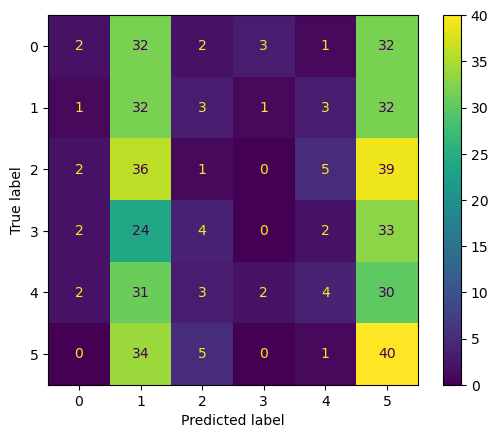

Optimized CNN accuracy: 0.17792792792792791


In [50]:
disp = sklearn.metrics.ConfusionMatrixDisplay(model_accuracy['item']['cm'])
disp.plot()
plt.show()
print('Optimized CNN accuracy: ' + str(model_accuracy['item']['accuracy']))

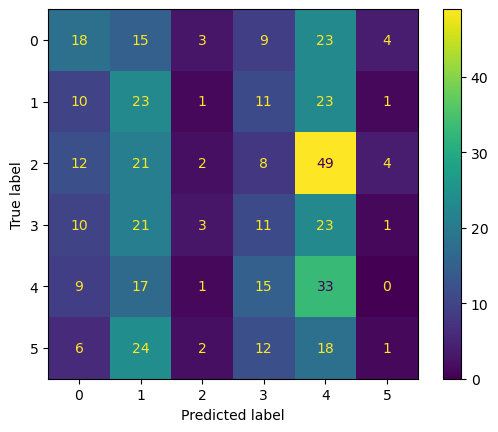

Optimized CNN accuracy: 0.1981981981981982


In [51]:
disp = sklearn.metrics.ConfusionMatrixDisplay(model_accuracy['delivery']['cm'])
disp.plot()
plt.show()
print('Optimized CNN accuracy: ' + str(model_accuracy['delivery']['accuracy']))

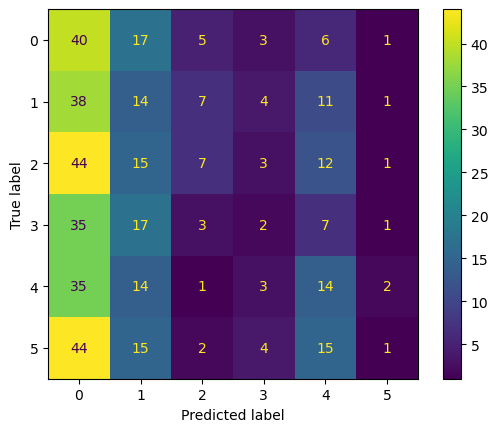

Optimized CNN accuracy: 0.17567567567567569


In [52]:
disp = sklearn.metrics.ConfusionMatrixDisplay(model_accuracy['seller']['cm'])
disp.plot()
plt.show()
print('Optimized CNN accuracy: ' + str(model_accuracy['seller']['accuracy']))

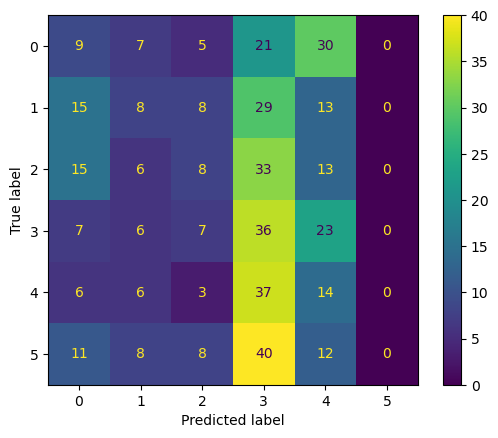

Optimized CNN accuracy: 0.16891891891891891


In [53]:
disp = sklearn.metrics.ConfusionMatrixDisplay(model_accuracy['marketplace']['cm'])
disp.plot()
plt.show()
print('Optimized CNN accuracy: ' + str(model_accuracy['marketplace']['accuracy']))

In [41]:
y_item_predicted = model_item.predict(np.expand_dims(X_item_test.toarray(), axis=2))
y_delivery_predicted = model_delivery.predict(np.expand_dims(X_delivery_test.toarray(), axis=2))
y_seller_predicted = model_seller.predict(np.expand_dims(X_seller_test.toarray(), axis=2))
y_marketplace_predicted = model_marketplace.predict(np.expand_dims(X_marketplace_test.toarray(), axis=2))

cm_item = sklearn.metrics.confusion_matrix(y_item_test, np.argmax(y_item_predicted, axis=1), labels=[0, 1, 2, 3, 4, 5])
cm_delivery = sklearn.metrics.confusion_matrix(y_delivery_test, np.argmax(y_delivery_predicted, axis=1), labels=[0, 1, 2, 3, 4, 5])
cm_seller = sklearn.metrics.confusion_matrix(y_seller_test, np.argmax(y_seller_predicted, axis=1), labels=[0, 1, 2, 3, 4, 5])
cm_marketplace = sklearn.metrics.confusion_matrix(y_marketplace_test, np.argmax(y_marketplace_predicted, axis=1), labels=[0, 1, 2, 3, 4, 5])

model_accuracy = {}

model_accuracy['item'] = {
    'accuracy': cm_item.diagonal().sum() / cm_item.sum(),
    'model': model_item,
    'cm': cm_item
}

model_accuracy['delivery'] = {
    'accuracy': cm_delivery.diagonal().sum() / cm_delivery.sum(),
    'model': model_delivery,
    'cm': cm_delivery
}

model_accuracy['seller'] = {
    'accuracy': cm_seller.diagonal().sum() / cm_seller.sum(),
    'model': model_seller,
    'cm': cm_seller
}

model_accuracy['marketplace'] = {
    'accuracy': cm_marketplace.diagonal().sum() / cm_marketplace.sum(),
    'model': model_marketplace,
    'cm': cm_marketplace
}

9/9 [==============================] - 0s 2ms/step


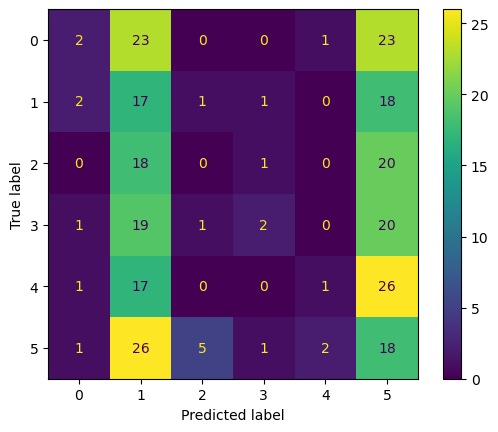

Optimized CNN accuracy: 0.14925373134328357


In [42]:
disp = sklearn.metrics.ConfusionMatrixDisplay(model_accuracy['item']['cm'])
disp.plot()
plt.show()
print('Optimized CNN accuracy: ' + str(model_accuracy['item']['accuracy']))

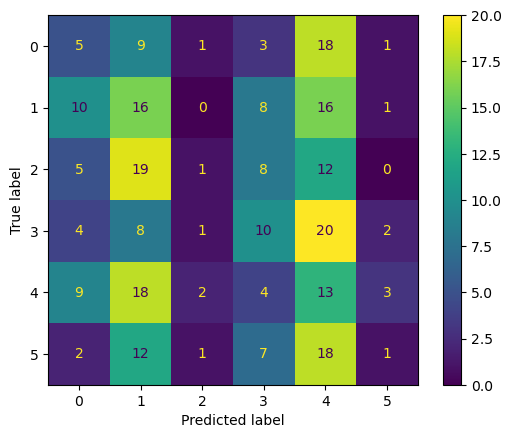

Optimized CNN accuracy: 0.17164179104477612


In [43]:
disp = sklearn.metrics.ConfusionMatrixDisplay(model_accuracy['delivery']['cm'])
disp.plot()
plt.show()
print('Optimized CNN accuracy: ' + str(model_accuracy['delivery']['accuracy']))

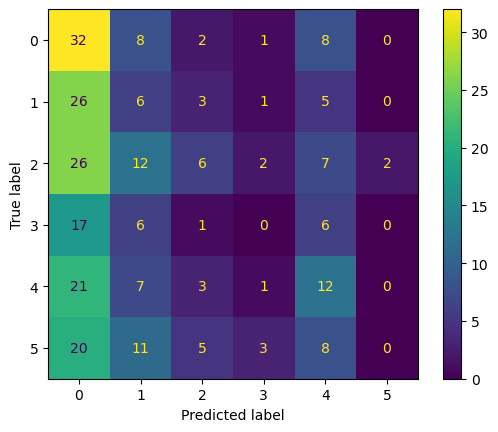

Optimized CNN accuracy: 0.208955223880597


In [44]:
disp = sklearn.metrics.ConfusionMatrixDisplay(model_accuracy['seller']['cm'])
disp.plot()
plt.show()
print('Optimized CNN accuracy: ' + str(model_accuracy['seller']['accuracy']))

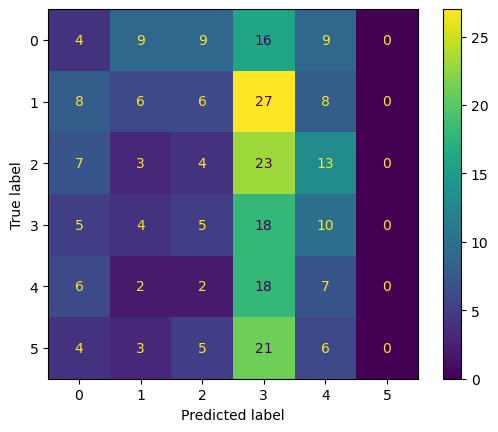

Optimized CNN accuracy: 0.1455223880597015


In [45]:
disp = sklearn.metrics.ConfusionMatrixDisplay(model_accuracy['marketplace']['cm'])
disp.plot()
plt.show()
print('Optimized CNN accuracy: ' + str(model_accuracy['marketplace']['accuracy']))

In [56]:
print('Model description for product')
print(classification_report(df_vr['rating_item'], np.argmax(y_vr_item_predict, axis=1)))

Model description for product
              precision    recall  f1-score   support

           0       0.22      0.03      0.05        72
           1       0.17      0.44      0.25        72
           2       0.06      0.01      0.02        83
           3       0.00      0.00      0.00        65
           4       0.25      0.06      0.09        72
           5       0.19      0.50      0.28        80

    accuracy                           0.18       444
   macro avg       0.15      0.17      0.11       444
weighted avg       0.15      0.18      0.12       444



In [57]:
print('Model description for delivery')
print(classification_report(df_vr['rating_delivery'], np.argmax(y_vr_delivery_predict, axis=1)))

Model description for delivery
              precision    recall  f1-score   support

           0       0.28      0.25      0.26        72
           1       0.19      0.33      0.24        69
           2       0.17      0.02      0.04        96
           3       0.17      0.16      0.16        69
           4       0.20      0.44      0.27        75
           5       0.09      0.02      0.03        63

    accuracy                           0.20       444
   macro avg       0.18      0.20      0.17       444
weighted avg       0.18      0.20      0.16       444



In [58]:
print('Model description for seller')
print(classification_report(df_vr['rating_seller'], np.argmax(y_vr_seller_predict, axis=1)))

Model description for seller
              precision    recall  f1-score   support

           0       0.17      0.56      0.26        72
           1       0.15      0.19      0.17        75
           2       0.28      0.09      0.13        82
           3       0.11      0.03      0.05        65
           4       0.22      0.20      0.21        69
           5       0.14      0.01      0.02        81

    accuracy                           0.18       444
   macro avg       0.18      0.18      0.14       444
weighted avg       0.18      0.18      0.14       444



In [59]:
print('Model description for the marketplace')
print(classification_report(df_vr['rating_marketplace'], np.argmax(y_vr_marketplace_predict, axis=1)))

Model description for the marketplace
              precision    recall  f1-score   support

           0       0.14      0.12      0.13        72
           1       0.20      0.11      0.14        73
           2       0.21      0.11      0.14        75
           3       0.18      0.46      0.26        79
           4       0.13      0.21      0.16        66
           5       0.00      0.00      0.00        79

    accuracy                           0.17       444
   macro avg       0.14      0.17      0.14       444
weighted avg       0.14      0.17      0.14       444



/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dmitry/.conda/envs/adsp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
